In [29]:
#------------------------------------------------------------------------------------------------------------------------------------------
# basic setup of the notebook
#------------------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import math
import timeit
import time
import sys
import os, shutil
from pip._vendor import tomli
from io import StringIO
sys.path.append('../code')
from fit_drivers import *
from minimizer import *
from fit_functions import *
from output_functions import *
from general_stats import *
from jpac_colors import *
import fit_drivers, minimizer, fit_functions, output_functions, general_stats 

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
from iminuit import minimize
from iminuit.util import describe
from typing import Annotated


# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

import os
print(os.environ['PATH'])
!which latex

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('coulomb')

iminuit version: 2.30.1
/opt/homebrew/bin:/Users/arodas/Library/Python/3.13/bin:/opt/homebrew/opt/llvm/bin:/opt/homebrew/sbin:/opt/homebrew/opt/libxml2/bin:/opt/homebrew/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Users/arodas/Library/Python/2.7/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/usr/local/share/dotnet:~/.dotnet/tools:/Applications/Visual Studio Code.app/Contents/Resources/app/bin:/opt/homebrew/opt/llvm/bin:/opt/homebrew/sbin:/opt/homebrew/opt/libxml2/bin:/opt/homebrew/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Users/arodas/Library/Python/2.7/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex

In [30]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Importing fixed params for analysis\
#------------------------------------------------------------------------------------------------------------------------------------------

with open('../ini_files/W_analysis_L20_xi=1.toml', "rb") as f:
    params = tomli.load(f)

with open('../ini_files/basic_setup.toml', "rb") as f2:
    params2 = tomli.load(f2)

for i in params:
     params['{}'.format(i)].update(params2['{}'.format(i)])

    
who            = params['creator']['who']
  
  
path           = params['paths_to_files']['base_path']
mainpath       = '{}{}'.format(path,params['paths_to_files']['mainpath'])
resultspath    = '{}{}'.format(path,params['paths_to_files']['resultspath'])
resultsdir     = '{}{}'.format(path,params['paths_to_files']['resultsdir'])
plotsdir       = '{}{}'.format(path,params['paths_to_files']['plotsdir'])
Gcplotsdir     = '{}{}'.format(path,params['paths_to_files']['Gcplotsdir'])
sizelabel      = params['paths_to_files']['sizelabel']      
  
als            = params['correlators']['als']
  
corrtype       = params['correlators']['corrtype']
xi             = params['correlators']['xi']
beta           = params['correlators']['beta']
betanorm       = params['correlators']['betanorm']
Lextent        = params['correlators']['Lextent']
Textent        = params['correlators']['Textent']
size           = params['correlators']['size']
Ncfgs          = params['correlators']['Ncfgs']
  
  
  
dini_Gc        = params['minimization_parameters']['dini_Gc']
dstop_Gc       = params['minimization_parameters']['dstop_Gc']
dmindata_Gc    = params['minimization_parameters']['dmindata_Gc']
dini_Vr        = params['minimization_parameters']['dini_Vr']
dstop_Vr       = params['minimization_parameters']['dstop_Vr']
dmindata_Vr    = params['minimization_parameters']['dmindata_Vr']
dfin_Gc        = params['minimization_parameters']['dfin_Gc']
dfin_Vr        = params['minimization_parameters']['dfin_Vr']
reuse          = params['minimization_parameters']['reuse']
inv_first      = params['minimization_parameters']['inv_first']
mcalls         = params['minimization_parameters']['mcalls']
mtol           = params['minimization_parameters']['mtol']
inipars_Gc     = params['minimization_parameters']['inipars_GC']
variants_Gc    = params['minimization_parameters']['variants_GC']
jackkl         = params['minimization_parameters']['jackkl']
xiini          = params['minimization_parameters']['xiini']
xifin          = params['minimization_parameters']['xifin']   
fileini        = params['minimization_parameters']['fileini']                         
filefin        = params['minimization_parameters']['filefin']
datatype_Gc    = params['minimization_parameters']['datatype_Gc']
model_Gc       = params['minimization_parameters']['model_Gc']
model_Vr       = params['minimization_parameters']['model_Vr']
datatype_Vr    = params['minimization_parameters']['datatype_Vr']
inipars_Vr     = params['minimization_parameters']['inipars_Vr']
variants_Vr    = params['minimization_parameters']['variants_Vr']
multiprocess   = params['minimization_parameters']['multiprocess']
improve        = params['minimization_parameters']['improve']

  
clean          = params['extra']['clean']
cutoff_ma      = params['extra']['cutoff_ma']
no_corrs       = params['extra']['no_corrs']

#cutoff_ma = 0.10

gev_m1_tofm=5.068
als=np.array(als)/gev_m1_tofm

als_orig=als*gev_m1_tofm

In [31]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Select data files to be fitted
#------------------------------------------------------------------------------------------------------------------------------------------

xirun    = xi[xiini:xifin+1]
betarun  = beta[fileini:filefin+1]

betarun=betarun[0:8]

#------------------------------------------------------------------------------------------------------------------------------------------
#Prepare options for fitting
#------------------------------------------------------------------------------------------------------------------------------------------
if (dini_Gc==0):
    diini  = 0
    distop = 0
else:
    diini   = dini_Gc
    distop  = dini_Gc+dstop_Gc

In [32]:
variants_Gc=['single', 'double']
labels=[]
for k in range(len(xirun)):
    output_file = open('../{}{}/{}_{}_{}_labels_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_nocorrs={}_{}.dat'.format(resultspath,xirun[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,no_corrs,corrtype), 'r')
    labelsread=output_file.readlines()
    labelsint=[]
    for i in range(len(betarun)):
        labelsint.append(labelsread[i])
    labels.append(labelsint)

def up_to_decimal(num, decimal):
   factor=1/decimal
   return np.ceil(num*factor)/factor

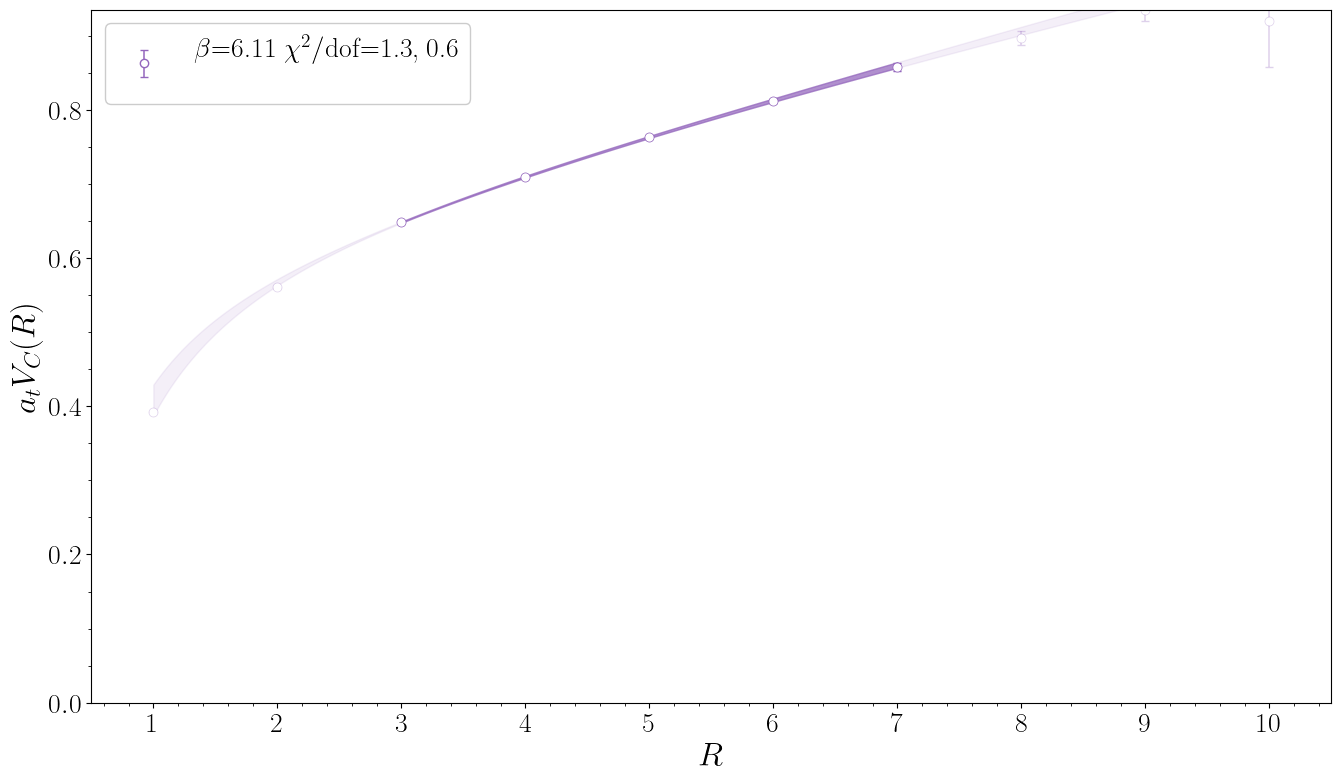

In [33]:
# Present the best and MA fits to the data

maxl=0

for k in range(len(xirun)):
    for i in range(len(betarun)):
        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxl=max(maxl,len(ensemble_stat(Vdat).mean()))

parlength=len(inipars_Vr[-1])
for k in range(len(xirun)):
    maxV=0
    minV=1
    plt.figure(figsize=(16,9))
    for i in range(len(betarun)):

        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxV=max(maxV,max(ensemble_stat(Vdat).mean()))
        minV=min(minV,min(ensemble_stat(Vdat).mean()))
        fit_list=np.loadtxt('../{}{}/{}_{}_{}_fits_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))
        fit_corr_list=np.loadtxt('../{}{}/{}_{}_{}_corrs_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))

        lt       = len(Vdat[0])
        data_t   = np.linspace(1, lt, lt)
        data_tf  = np.linspace(1, lt, 100*lt)
        data_y   = ensemble_stat(Vdat).mean()
        data_cov = ensemble_stat(Vdat).rcov()     # Do not use these non-diagonal elements, they come from a rescaled sample, they are not correct
        data_err = np.sqrt(np.diagonal(ensemble_stat(Vdat).rcov()))

        bf_data_t=data_t[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_y=data_y[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_err=data_err[int(fit_list[0])-1:int(fit_list[1])]

        bf_data_tf= np.linspace(bf_data_t[0], bf_data_t[-1], 100*len(bf_data_t))

        indexini=2
        pars=np.array(fit_list[indexini:indexini+parlength])
        epars=np.array(fit_list[indexini+parlength:indexini+2*parlength])
        cpars=np.array(fit_corr_list[0:parlength])

        fit     = eval(model_Vr)(data_tf,*pars)
        efit    = prop_err(data_tf,model_Vr,pars,epars,cpars)
        fits    = eval(model_Vr)(bf_data_tf,*pars)
        efits   = prop_err(bf_data_tf,model_Vr,pars,epars,cpars)

        mapars  = np.array(fit_list[indexini+2*parlength:indexini+3*parlength])
        emapars = np.array(fit_list[indexini+3*parlength:indexini+4*parlength])
        macpars = np.array(fit_corr_list[parlength:2*parlength])

        mafit   = eval(model_Vr)(data_tf,*mapars)
        emafit  = prop_err(data_tf,model_Vr,mapars,emapars,macpars)
        mafits  = eval(model_Vr)(bf_data_tf,*mapars)
        emafits = prop_err(bf_data_tf,model_Vr,mapars,emapars,macpars)

        shift=0.05
        #plt.fill_between(data_tf+shift*i, mafit+emafit, mafit-emafit,color=jpac_color_around[i],alpha=0.1)
        plt.fill_between(data_tf+shift*i, fit+efit, fit-efit,color=jpac_color_around[i],alpha=0.1)
        #plt.fill_between(bf_data_tf+shift*i, mafits+emafits, mafits-emafits,color=jpac_color_around[i],alpha=0.7)
        plt.fill_between(bf_data_tf+shift*i, fits+efits, fits-efits,color=jpac_color_around[i],alpha=0.7)
        plt.errorbar(data_t+shift*i, data_y, data_err, fmt=markerlist[i], alpha=0.3, color=jpac_color_around[i],markerfacecolor='white')
        plt.errorbar(bf_data_t+shift*i, bf_data_y, bf_data_err, fmt=markerlist[i], label=labels[k][i], color=jpac_color_around[i],markerfacecolor='white')
        plt.errorbar(data_t+shift*i, data_y, fmt=markerlist[i], alpha=1, color=jpac_color_around[i],markerfacecolor='white',markeredgecolor='none')

        

    if (corrtype=='g'):
        if (datatype_Gc=='exp_WL'):
            corrplot='G_phys'
        else:
            corrplot='G_0'
    elif (corrtype=='w'):
        corrplot='W_phys'

    plt.legend(fontsize=20,frameon=True,loc='upper left',ncols=2,fancybox=True,shadow=False,framealpha=1)
    plt.xlabel('$R$')
    #plt.yticks(np.linspace(0,20,41))
    plt.ylim(0.,maxV)
    #,min(up_to_decimal(maxV,0.5),5))
    plt.xticks(np.linspace(0,maxl,maxl+1))
    plt.xlim(0.5,maxl+0.5)
    plt.ylabel("$a_tV_C(R)$", rotation=90, loc='center')
    #plt.title('$\\xi={}\,$'.format(xi[k]),fontsize=20, pad=20)
    plt.savefig('../{}/{}_{}_{}_VR_fits_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_xi={}_nocorrs={}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,xi[k],no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

0.2118616779533126
0.9433901166074349


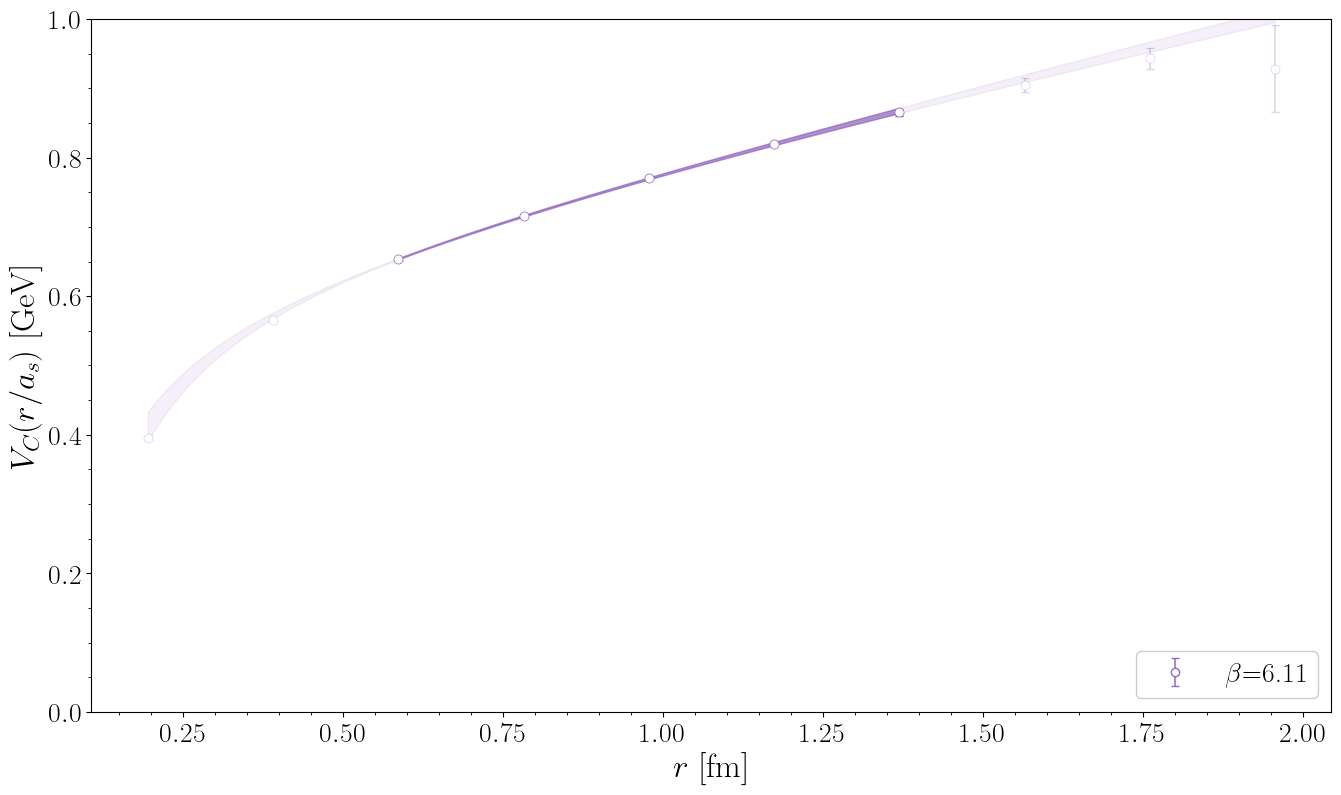

In [34]:
# Present the best and MA fits to the data in physical units

maxl=0
shift=0.
shifty=1

for k in range(len(xirun)):
    for i in range(len(betarun)):
        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxl=max(maxl,len(ensemble_stat(Vdat).mean()))

parlength=len(inipars_Vr[-1])
for k in range(len(xirun)):
    xival=k+1
    maxV=0
    minV=1
    plt.figure(figsize=(16,9))
    for i in range(len(betarun)):
        at=als_orig[k][i]/xival
        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxV=max(maxV,max(ensemble_stat(Vdat).mean()/at)+shifty*i)
        minV=min(minV,min(ensemble_stat(Vdat).mean()/at)+shifty*i)
        fit_list=np.loadtxt('../{}{}/{}_{}_{}_fits_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))
        fit_corr_list=np.loadtxt('../{}{}/{}_{}_{}_corrs_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))

        lt       = len(Vdat[0])
        data_t   = np.linspace(1, lt, lt)
        data_tf  = np.linspace(1, lt, 100*lt)
        data_y   = ensemble_stat(Vdat).mean()/at
        data_cov = ensemble_stat(Vdat).rcov()     # Do not use these non-diagonal elements, they come from a rescaled sample, they are not correct
        data_err = np.sqrt(np.diagonal(ensemble_stat(Vdat).rcov()))/at

        bf_data_t=data_t[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_y=data_y[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_err=data_err[int(fit_list[0])-1:int(fit_list[1])]

        bf_data_tf= np.linspace(bf_data_t[0], bf_data_t[-1], 100*len(bf_data_t))

        indexini=2
        pars=np.array(fit_list[indexini:indexini+parlength])
        epars=np.array(fit_list[indexini+parlength:indexini+2*parlength])
        cpars=np.array(fit_corr_list[0:parlength])

        fit     = eval(model_Vr)(data_tf,*pars)/at
        efit    = prop_err(data_tf,model_Vr,pars,epars,cpars)/at
        fits    = eval(model_Vr)(bf_data_tf,*pars)/at
        efits   = prop_err(bf_data_tf,model_Vr,pars,epars,cpars)/at

        mapars  = np.array(fit_list[indexini+2*parlength:indexini+3*parlength])
        emapars = np.array(fit_list[indexini+3*parlength:indexini+4*parlength])
        macpars = np.array(fit_corr_list[parlength:2*parlength])

        mafit   = eval(model_Vr)(data_tf,*mapars)
        emafit  = prop_err(data_tf,model_Vr,mapars,emapars,macpars)
        mafits  = eval(model_Vr)(bf_data_tf,*mapars)
        emafits = prop_err(bf_data_tf,model_Vr,mapars,emapars,macpars)

        
        #plt.fill_between(data_tf+shift*i, mafit+emafit, mafit-emafit,color=jpac_color_around[i],alpha=0.1)
        plt.fill_between((data_tf+shift*i)*als[k][i], fit+efit+shifty*i, fit-efit+shifty*i,color=jpac_color_around[i],alpha=0.1)
        #plt.fill_between(bf_data_tf+shift*i, mafits+emafits, mafits-emafits,color=jpac_color_around[i],alpha=0.7)
        plt.fill_between((bf_data_tf+shift*i)*als[k][i], fits+efits+shifty*i, fits-efits+shifty*i,color=jpac_color_around[i],alpha=0.7)
        plt.errorbar((data_t+shift*i)*als[k][i], data_y+shifty*i, data_err, fmt=markerlist[i], alpha=0.3, color=jpac_color_around[i],markerfacecolor='white')
        plt.errorbar((bf_data_t+shift*i)*als[k][i], bf_data_y+shifty*i, bf_data_err, fmt=markerlist[i], label=labels[k][i][0:12], color=jpac_color_around[i],markerfacecolor='white')
        plt.errorbar((data_t+shift*i)*als[k][i], data_y+shifty*i, fmt=markerlist[i], alpha=1, color=jpac_color_around[i],markerfacecolor='white',markeredgecolor='none')

        print(mapars[2]/als_orig[k][i]**2*xival/0.44**2)
        
    print(maxV)

    if (corrtype=='g'):
        if (datatype_Gc=='exp_WL'):
            corrplot='G_phys'
        else:
            corrplot='G_0'
    elif (corrtype=='w'):
        corrplot='W_phys'


    plt.legend(fontsize=20,frameon=True,loc='lower right',ncols=2,fancybox=True,shadow=False,framealpha=1)
    plt.xlabel('$r$ [fm]')
    #plt.yticks(np.linspace(0,20,41))
    plt.ylim(0.,min(up_to_decimal(maxV,0.1),15))
    #plt.xticks(np.linspace(0,maxl,maxl+1))
    #plt.xlim(0,(maxl+0.5)
    plt.ylabel("$V_C(r/a_s)$ [GeV]", rotation=90, loc='center')
    #plt.title('$\\xi={}\,$'.format(xi[k]),fontsize=20, pad=20)
    plt.savefig('../{}/{}_{}_{}_VR_fits_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_xi={}_nocorrs={}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,xi[k],no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

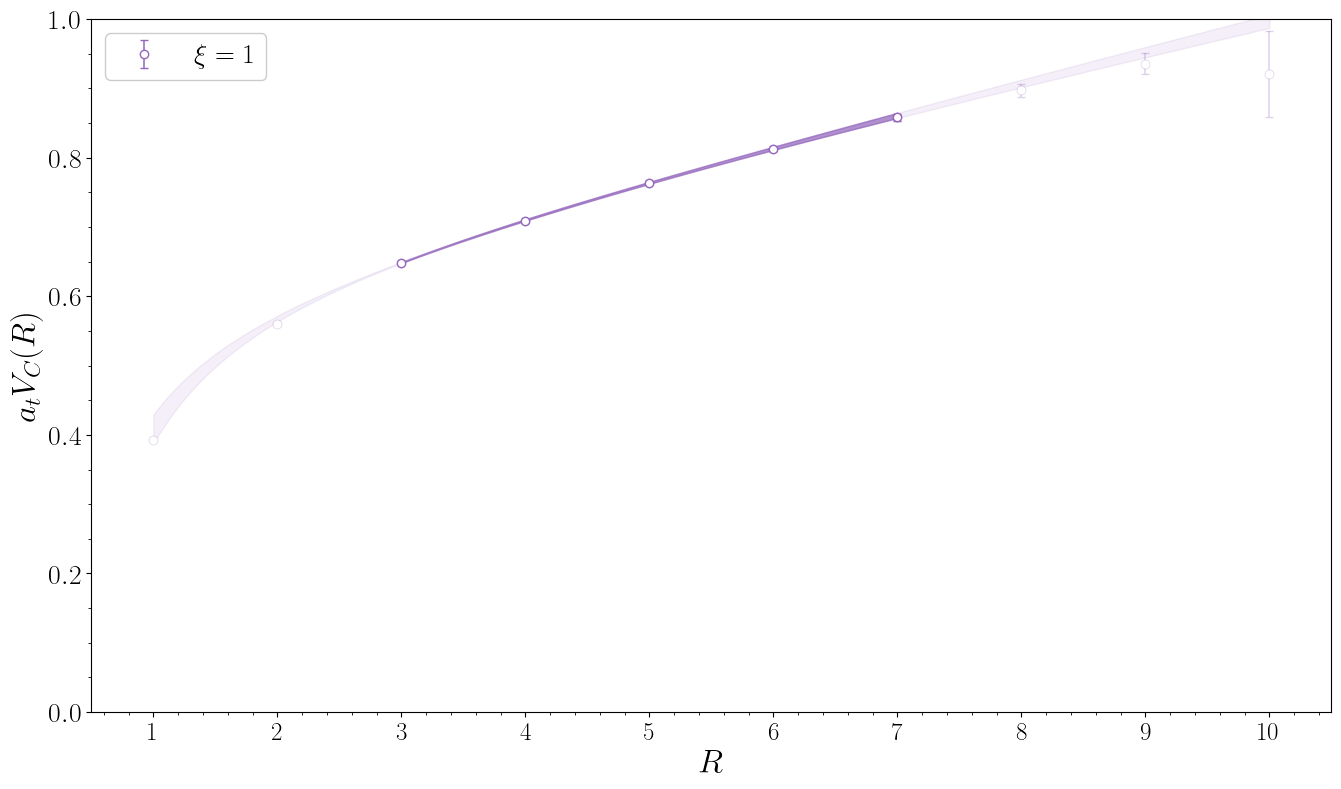

In [35]:
# Present the best and MA fits to the data

maxl=0

for k in range(len(xirun)):
    for i in range(len(betarun)):
        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxl=max(maxl,len(ensemble_stat(Vdat).mean()))

parlength=len(inipars_Vr[-1])
for i in range(len(betarun)):
    maxV=0
    minV=1
    plt.figure(figsize=(16,9))
    for k in range(len(xirun)):

        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxV=max(maxV,max(ensemble_stat(Vdat).mean()))
        minV=min(minV,min(ensemble_stat(Vdat).mean()))
        fit_list=np.loadtxt('../{}{}/{}_{}_{}_fits_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))
        fit_corr_list=np.loadtxt('../{}{}/{}_{}_{}_corrs_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))

        lt       = len(Vdat[0])
        data_t   = np.linspace(1, lt, lt)
        data_tf  = np.linspace(1, lt, 100*lt)
        data_y   = ensemble_stat(Vdat).mean()
        data_cov = ensemble_stat(Vdat).rcov()     # Do not use these non-diagonal elements, they come from a rescaled sample, they are not correct
        data_err = np.sqrt(np.diagonal(ensemble_stat(Vdat).rcov()))

        bf_data_t=data_t[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_y=data_y[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_err=data_err[int(fit_list[0])-1:int(fit_list[1])]

        bf_data_tf= np.linspace(bf_data_t[0], bf_data_t[-1], 100*len(bf_data_t))

        indexini=2
        pars=np.array(fit_list[indexini:indexini+parlength])
        epars=np.array(fit_list[indexini+parlength:indexini+2*parlength])
        cpars=np.array(fit_corr_list[0:parlength])

        fit     = eval(model_Vr)(data_tf,*pars)
        efit    = prop_err(data_tf,model_Vr,pars,epars,cpars)
        fits    = eval(model_Vr)(bf_data_tf,*pars)
        efits   = prop_err(bf_data_tf,model_Vr,pars,epars,cpars)

        mapars  = np.array(fit_list[indexini+2*parlength:indexini+3*parlength])
        emapars = np.array(fit_list[indexini+3*parlength:indexini+4*parlength])
        macpars = np.array(fit_corr_list[parlength:2*parlength])

        mafit   = eval(model_Vr)(data_tf,*mapars)
        emafit  = prop_err(data_tf,model_Vr,mapars,emapars,macpars)
        mafits  = eval(model_Vr)(bf_data_tf,*mapars)
        emafits = prop_err(bf_data_tf,model_Vr,mapars,emapars,macpars)

        shift=0.05
        #plt.fill_between(data_tf+shift*k, mafit+emafit, mafit-emafit,color=jpac_color_around[k],alpha=0.1)
        #plt.fill_between(bf_data_tf+shift*k, mafits+emafits, mafits-emafits,color=jpac_color_around[k],alpha=0.7)
        plt.fill_between(data_tf+shift*k, fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
        plt.fill_between(bf_data_tf+shift*k, fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)
        plt.errorbar(data_t+shift*k, data_y, data_err, fmt=markerlist[k], alpha=0.3, color=jpac_color_around[k],markerfacecolor='white')
        plt.errorbar(data_t+shift*k, data_y, fmt=markerlist[k], alpha=1, color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none')
        plt.errorbar(bf_data_t+shift*k, bf_data_y, bf_data_err, fmt=markerlist[k], label='$\\xi={}$'.format(xi[k]), color=jpac_color_around[k],markerfacecolor='white')

        
    if (corrtype=='g'):
        if (datatype_Gc=='exp_WL'):
            corrplot='G_phys'
        else:
            corrplot='G_0'
    elif (corrtype=='w'):
        corrplot='W_phys'

    plt.legend(fontsize=20,frameon=True,loc='upper left',ncols=2,fancybox=True,shadow=False,framealpha=1)
    
    plt.xlabel("$R$")
    #plt.yticks(np.linspace(0,20,41),fontsize=18)
    plt.ylim(0.,min(up_to_decimal(maxV,0.5),5))
    plt.xticks(np.linspace(0,maxl,maxl+1),fontsize=18)
    plt.xlim(0.5,maxl+0.5)
    plt.ylabel("$a_tV_C(R)$", rotation=90, loc='center')
    #plt.title('$\\beta={}\,$'.format(betarun[i]/betanorm),fontsize=20, pad=20)    
    plt.savefig('../{}/{}_{}_{}_VR_fits_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()

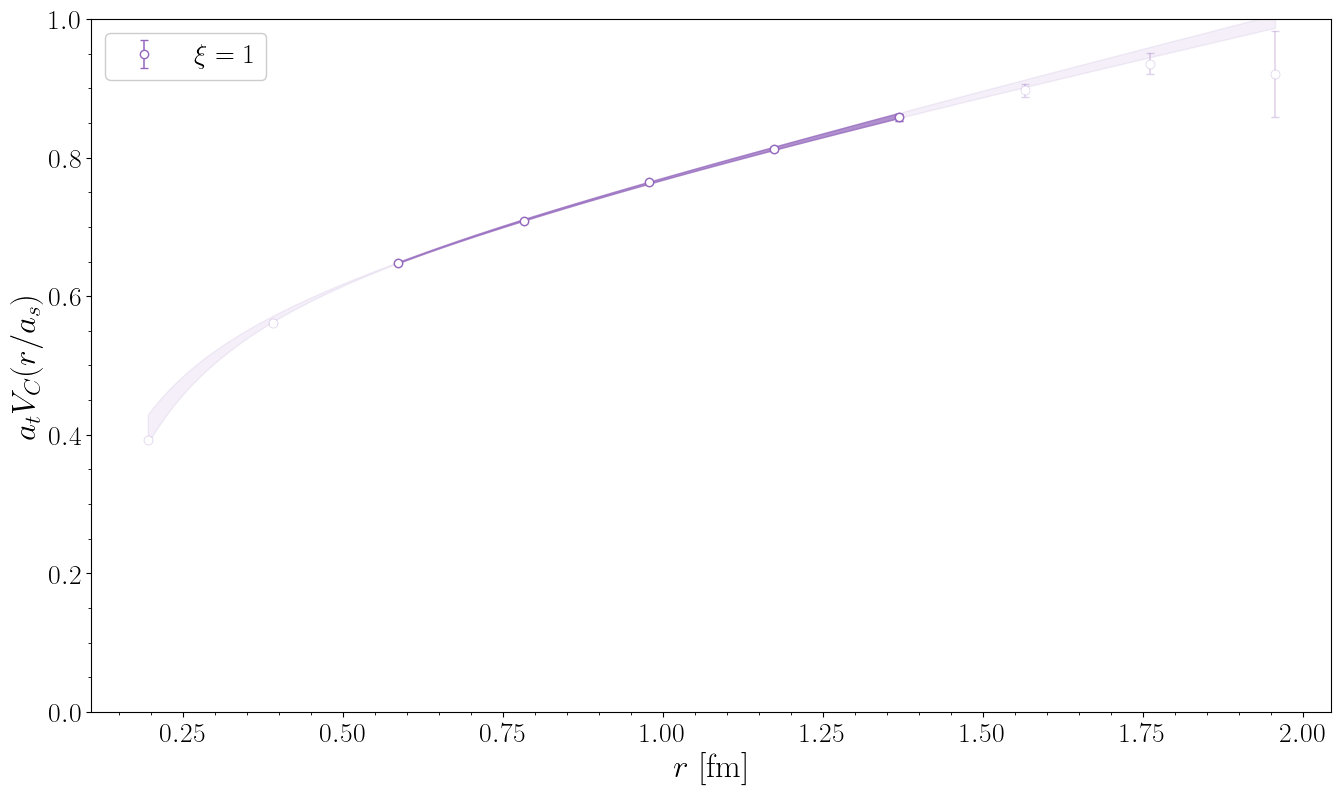

In [36]:
# Present the best and MA fits to the data

maxl=0

for k in range(len(xirun)):
    for i in range(len(betarun)):
        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxl=max(maxl,len(ensemble_stat(Vdat).mean()))

parlength=len(inipars_Vr[-1])
for i in range(len(betarun)):
    maxV=0
    minV=1
    plt.figure(figsize=(16,9))
    for k in range(len(xirun)):

        Vdat=np.loadtxt('../{}{}/{}_{}_{}_VR_rescaled_ti{}_{}_tfin{}_tmin{}_cut{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,cutoff_ma,betarun[i],no_corrs,corrtype))
        maxV=max(maxV,max(ensemble_stat(Vdat).mean()))
        minV=min(minV,min(ensemble_stat(Vdat).mean()))
        fit_list=np.loadtxt('../{}{}/{}_{}_{}_fits_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))
        fit_corr_list=np.loadtxt('../{}{}/{}_{}_{}_corrs_VR_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.dat'.format(resultspath,xi[k],len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype))

        lt       = len(Vdat[0])
        data_t   = np.linspace(1, lt, lt)
        data_tf  = np.linspace(1, lt, 100*lt)
        data_y   = ensemble_stat(Vdat).mean()
        data_cov = ensemble_stat(Vdat).rcov()     # Do not use these non-diagonal elements, they come from a rescaled sample, they are not correct
        data_err = np.sqrt(np.diagonal(ensemble_stat(Vdat).rcov()))

        bf_data_t=data_t[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_y=data_y[int(fit_list[0])-1:int(fit_list[1])]
        bf_data_err=data_err[int(fit_list[0])-1:int(fit_list[1])]

        bf_data_tf= np.linspace(bf_data_t[0], bf_data_t[-1], 100*len(bf_data_t))

        indexini=2
        pars=np.array(fit_list[indexini:indexini+parlength])
        epars=np.array(fit_list[indexini+parlength:indexini+2*parlength])
        cpars=np.array(fit_corr_list[0:parlength])

        fit     = eval(model_Vr)(data_tf,*pars)
        efit    = prop_err(data_tf,model_Vr,pars,epars,cpars)
        fits    = eval(model_Vr)(bf_data_tf,*pars)
        efits   = prop_err(bf_data_tf,model_Vr,pars,epars,cpars)

        mapars  = np.array(fit_list[indexini+2*parlength:indexini+3*parlength])
        emapars = np.array(fit_list[indexini+3*parlength:indexini+4*parlength])
        macpars = np.array(fit_corr_list[parlength:2*parlength])

        mafit   = eval(model_Vr)(data_tf,*mapars)
        emafit  = prop_err(data_tf,model_Vr,mapars,emapars,macpars)
        mafits  = eval(model_Vr)(bf_data_tf,*mapars)
        emafits = prop_err(bf_data_tf,model_Vr,mapars,emapars,macpars)

        shift=0.0
        #plt.fill_between(data_tf+shift*k, mafit+emafit, mafit-emafit,color=jpac_color_around[k],alpha=0.1)
        #plt.fill_between(bf_data_tf+shift*k, mafits+emafits, mafits-emafits,color=jpac_color_around[k],alpha=0.7)
        plt.fill_between((data_tf+shift*k)*als[k][i], fit+efit, fit-efit,color=jpac_color_around[k],alpha=0.1)
        plt.fill_between((bf_data_tf+shift*k)*als[k][i], fits+efits, fits-efits,color=jpac_color_around[k],alpha=0.7)
        plt.errorbar((data_t+shift*k)*als[k][i], data_y, data_err, fmt=markerlist[k], alpha=0.3, color=jpac_color_around[k],markerfacecolor='white')
        plt.errorbar((data_t+shift*k)*als[k][i], data_y, fmt=markerlist[k], alpha=1, color=jpac_color_around[k],markerfacecolor='white',markeredgecolor='none')
        plt.errorbar((bf_data_t+shift*k)*als[k][i], bf_data_y, bf_data_err, fmt=markerlist[k], label='$\\xi={}$'.format(xi[k]), color=jpac_color_around[k],markerfacecolor='white')

        
    if (corrtype=='g'):
        if (datatype_Gc=='exp_WL'):
            corrplot='G_phys'
        else:
            corrplot='G_0'
    elif (corrtype=='w'):
        corrplot='W_phys'

    plt.legend(fontsize=20,frameon=True,loc='upper left',ncols=2,fancybox=True,shadow=False,framealpha=1)
    
    plt.xlabel("$r$ [fm]")
    #plt.yticks(np.linspace(0,20,41),fontsize=18)
    plt.ylim(0.,min(up_to_decimal(maxV,0.5),5))
    #plt.xticks(np.linspace(0,maxl,maxl+1),fontsize=18)
    #plt.xlim(0.5,maxl+0.5)
    plt.ylabel("$a_tV_C(r/a_s)$", rotation=90, loc='center')
    #plt.title('$\\beta={}\,$'.format(betarun[i]/betanorm),fontsize=20, pad=20)    
    plt.savefig('../{}/{}_{}_{}_VR_fits_ti{}_{}_tfin{}_tmin{}_rmin{}_{}_rfin{}_beta={}_nocorrs={}_{}.pdf'.format(plotsdir,len(variants_Gc),model_Gc,datatype_Gc,diini,dstop_Gc,dfin_Gc,dmindata_Gc,dini_Vr,dstop_Vr,dfin_Vr,betarun[i],no_corrs,corrtype), format="pdf", bbox_inches='tight', pad_inches=0.2)
    plt.show()